# Vgg19 model

### Table of contents

1. Training model.<br>
2. Regularizing model with data augmentation.<br>
3. Regularizing model with kernel regularization.<br>
4. Unfreeze more layers to improve training accuracy.<br>
5. Regularizing model with dropout regularization.<br>

In [0]:
# Importing neccessary packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import json
from utils import add_regularization, get_data_generators, plot_model_results
from Models import TrainingCheckpoint, ModelTrain

In [0]:
NUM_CLASSES = 11
with open('classes_list.json', 'r') as fp:
    classes_list = json.load(fp)

In [0]:
# Data augmentation for regularization and adding some extra training samples

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rescale=1.0/255.0,
    horizontal_flip=True, 
    zoom_range=0.2,
    shear_range=0.2
)

In [0]:
TARGET_DIM = 300
BATCH_SIZE = 32

In [0]:
train_generator, validation_generator = get_data_generators(datagen, TARGET_DIM, BATCH_SIZE)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [0]:
train_generator.class_indices

{'Bread': 0,
 'Dairyproduct': 1,
 'Dessert': 2,
 'Egg': 3,
 'Friedfood': 4,
 'Meat': 5,
 'NoodlesPasta': 6,
 'Rice': 7,
 'Seafood': 8,
 'Soup': 9,
 'VegetableFruit': 10}

In [0]:
validation_generator.class_indices

{'Bread': 0,
 'Dairyproduct': 1,
 'Dessert': 2,
 'Egg': 3,
 'Friedfood': 4,
 'Meat': 5,
 'NoodlesPasta': 6,
 'Rice': 7,
 'Seafood': 8,
 'Soup': 9,
 'VegetableFruit': 10}

In [0]:
# Lets try the Vgg19 architecture

base_model = tf.keras.applications.vgg19.VGG19(
    include_top=False, 
    weights='imagenet', 
    input_shape=(TARGET_DIM, TARGET_DIM, 3)
)

80142336/80134624 [==============================] - 1s 0us/step


In [0]:
print('Layers in Vgg19: ' + str(len(base_model.layers)))

Layers in Vgg19: 22


In [0]:
preds = base_model.output
preds = tf.keras.layers.GlobalAveragePooling2D()(preds)
preds = tf.keras.layers.Dense(1024, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.BatchNormalization()(preds)
preds = tf.keras.layers.Dense(512, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.BatchNormalization()(preds)
preds = tf.keras.layers.Dense(256, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.BatchNormalization()(preds)
preds = tf.keras.layers.Dense(128, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.Dense(11, activation=tf.nn.softmax)(preds)

In [0]:
model = tf.keras.models.Model(base_model.input, preds)

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [0]:
vgg19 = ModelTrain(model, TARGET_DIM, BATCH_SIZE)
vgg19.freeze_layers(9)

In [0]:
vgg19.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [0]:
vgg19.model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [0]:
# Lets define checkpoint for model saving
filepath="./models/vgg19-{epoch:02d}-{acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

training_checkpoint = TrainingCheckpoint()

csv_logger = tf.keras.callbacks.CSVLogger(filename='./logs/vgg19_training.csv', append=True)

In [0]:
#Let's train the model 20 epochs as it will take a lot of time

vgg19.model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, csv_logger, training_checkpoint],
    epochs=60
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/60
308/308 [==============================] - ETA: 0s - loss: 1.1854 - acc: 0.6048
Epoch 00001: acc improved from -inf to 0.60484, saving model to ./drive/My Drive/food_11_weights/vgg19-01-0.60.hdf5
308/308 [==============================] - 306s 993ms/step - loss: 1.1854 - acc: 0.6048 - val_loss: 1.3001 - val_acc: 0.5584
Epoch 2/60
308/308 [==============================] - ETA: 0s - loss: 0.9147 - acc: 0.6920
Epoch 00002: acc improved from 0.60484 to 0.69199, saving model to ./drive/My Drive/food_11_weights/vgg19-02-0.69.hdf5
308/308 [==============================] - 310s 1s/step - loss: 0.9147 - acc: 0.6920 - val_loss: 1.1871 - val_acc: 0.6116
Epoch 3/60
308/308 [==============================] - ETA: 0s - loss: 0.8209 - acc: 0.7181
Epoch 00003: acc improved from 0.69199 to 0.71812, saving model to ./drive/My Drive/food_11_weights/vgg19-03-0.72.hdf5
308/308 [==============================] - 310s 1s

### Results

Training accuracy: 0.9027<br>
Training loss: 0.2805 <br>

Validation accuracy: 0.7328<br>
Validation loss: 1.0398<br>

Avoidable bias error: 0.0973 => 9.73%<br>
Variance error: 0.1699 => 16.99%<br>

### Conclusion:

Here variance error is higher than avoidable bias, so we need to regularize the model.

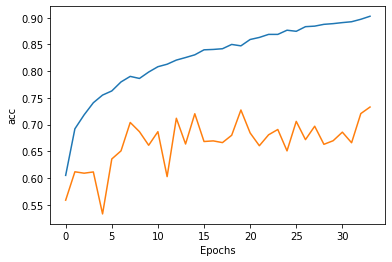

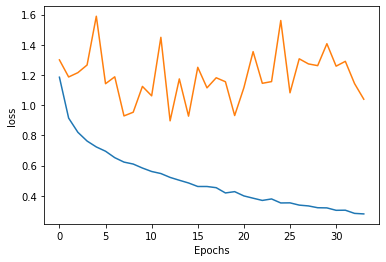

In [0]:
model_history = vgg19.model.history.history

plot_model_results(34, model_history, 'acc')
plot_model_results(34, model_history, 'loss')

### Regularizing model

Let's use following techniques to regularize the model step by step:
1. Data augmentation. <br>
2. Adding weight regularization.<br>
3. Adding dropout. <br>


In [0]:
model = tf.keras.models.load_model('./models/vgg19-34-0.90.hdf5')

### Data augmentation

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rescale=1.0/255.0,
    horizontal_flip=True, 
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=30
)

In [16]:
train_generator, validation_generator = get_data_generators(datagen, TARGET_DIM, BATCH_SIZE)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [0]:
# Lets define checkpoint for model saving
filepath="./models/vgg19-regularized-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_checkpoint = TrainingCheckpoint()

csv_logger = tf.keras.callbacks.CSVLogger(filename='./logs/vgg19_regularized.csv', append=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, mode='max')

In [0]:
model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, csv_logger, training_checkpoint, early_stopping],
    epochs=20
)

Epoch 1/20
308/308 [==============================] - ETA: 0s - loss: 0.4686 - acc: 0.8350
Epoch 00001: val_acc improved from -inf to 0.67553, saving model to ./drive/My Drive/food_11_weights/vgg19-regularized-01-0.68.hdf5
308/308 [==============================] - 305s 992ms/step - loss: 0.4686 - acc: 0.8350 - val_loss: 1.0762 - val_acc: 0.6755
Epoch 2/20
308/308 [==============================] - ETA: 0s - loss: 0.4549 - acc: 0.8433
Epoch 00002: val_acc improved from 0.67553 to 0.68166, saving model to ./drive/My Drive/food_11_weights/vgg19-regularized-02-0.68.hdf5
308/308 [==============================] - 313s 1s/step - loss: 0.4549 - acc: 0.8433 - val_loss: 1.1858 - val_acc: 0.6817
Epoch 3/20
308/308 [==============================] - ETA: 0s - loss: 0.4691 - acc: 0.8336
Epoch 00003: val_acc did not improve from 0.68166
308/308 [==============================] - 313s 1s/step - loss: 0.4691 - acc: 0.8336 - val_loss: 1.2313 - val_acc: 0.6653
Epoch 4/20
308/308 [=====================

### Results

Training accuracy: 0.8549<br>
Training loss: 0.4154 <br>

Validation accuracy: 0.7036<br>
Validation loss: 1.0596<br>

Avoidable bias error: 0.1551 => 15.51%<br>
Variance error: 0.1513 => 15.13%<br>

### Conclusion:

Here avoidable bias is higher than variance error, but training further won't help as the model won't be generalized instead lets focus on reducing variance.

### Kernel regularization

In [0]:
## Adding weight regularization to dense_1 and dense_3 layers.
weight_regularization_layers = [model.layers[-2], model.layers[-6]]
model = add_regularization(model, weight_regularization_layers, regularizer=tf.keras.regularizers.l2(l=0.003))

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [0]:
model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, csv_logger, training_checkpoint, early_stopping],
    epochs=20
)

Epoch 1/20
308/308 [==============================] - ETA: 0s - loss: 6.2717 - acc: 0.8498
Epoch 00001: val_acc did not improve from 0.71057
308/308 [==============================] - 302s 980ms/step - loss: 6.2717 - acc: 0.8498 - val_loss: 2.7301 - val_acc: 0.7103
Epoch 2/20
308/308 [==============================] - ETA: 0s - loss: 1.6931 - acc: 0.8155
Epoch 00002: val_acc did not improve from 0.71057
308/308 [==============================] - 301s 977ms/step - loss: 1.6931 - acc: 0.8155 - val_loss: 1.7497 - val_acc: 0.6779
Epoch 3/20
308/308 [==============================] - ETA: 0s - loss: 1.2010 - acc: 0.7920
Epoch 00003: val_acc did not improve from 0.71057
308/308 [==============================] - 301s 978ms/step - loss: 1.2010 - acc: 0.7920 - val_loss: 1.3954 - val_acc: 0.7071
Epoch 4/20
308/308 [==============================] - ETA: 0s - loss: 1.0524 - acc: 0.7915
Epoch 00004: val_acc improved from 0.71057 to 0.71320, saving model to ./drive/My Drive/food_11_weights/vgg19-r

### Results

Training accuracy: 0.7915<br>
Training loss: 1.0524 <br>

Validation accuracy: 0.7132<br>
Validation loss: 1.3057<br>

Avoidable bias error: 0.2085 => 20.85%<br>
Variance error: 0.0782 => 7.82%<br>

### Conclusion:

Lets try to reduce the bias by further training network by unfreezing 2 convolutional layers.

## Unfreeze more layers

In [0]:
model = tf.keras.models.load_model('./models/vgg19-regularized-04-0.71.hdf5')

In [34]:
# Let's add a dropout layer 
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [0]:
## Let's unfreeze the last 2 layers of base model. 
vgg19 = ModelTrain(model, TARGET_DIM, BATCH_SIZE)

In [0]:
vgg19.freeze_layers(11)

In [0]:
vgg19.model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [38]:
%%time
vgg19.model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, csv_logger, training_checkpoint],
    epochs=20
)

Epoch 1/20
308/308 [==============================] - ETA: 0s - loss: 1.4505 - acc: 0.6280
Epoch 00001: val_acc improved from -inf to 0.53826, saving model to ./drive/My Drive/food_11_weights/vgg19-regularized-01-0.54.hdf5
308/308 [==============================] - 422s 1s/step - loss: 1.4505 - acc: 0.6280 - val_loss: 1.8585 - val_acc: 0.5383
Epoch 2/20
308/308 [==============================] - ETA: 0s - loss: 1.1319 - acc: 0.7026
Epoch 00002: val_acc did not improve from 0.53826
308/308 [==============================] - 419s 1s/step - loss: 1.1319 - acc: 0.7026 - val_loss: 1.8168 - val_acc: 0.5172
Epoch 3/20
308/308 [==============================] - ETA: 0s - loss: 1.0248 - acc: 0.7296
Epoch 00003: val_acc improved from 0.53826 to 0.63347, saving model to ./drive/My Drive/food_11_weights/vgg19-regularized-03-0.63.hdf5
308/308 [==============================] - 418s 1s/step - loss: 1.0248 - acc: 0.7296 - val_loss: 1.3097 - val_acc: 0.6335
Epoch 4/20
308/308 [========================

### Results

Training accuracy: 0.8458<br>
Training loss: 0.6053 <br>

Validation accuracy: 0.7775<br>
Validation loss: 0.8480<br>

Avoidable bias error: 0.1542 => 15.42%<br>
Variance error: 0.0717 => 7.17%<br>

### Conclusion:
It appears that validation accuracy is not improving above 77% because of class imbalance problem, so though bias error is higher than variance error, reducing the bias error further will only overfit the model. So let's try to reduce variance error instead.

## Adding dropout regularization

In [0]:
model = tf.keras.models.load_model('./models/vgg19-regularized-18-0.78.hdf5')

In [0]:
preds = model.layers[-8].output
preds = tf.keras.layers.Dropout(rate=0.4)(preds)
preds = model.layers[-7](preds)
preds = model.layers[-6](preds)
preds = model.layers[-5](preds)
preds = model.layers[-4](preds)
preds = tf.keras.layers.Dropout(rate=0.3)(preds)
preds = model.layers[-3](preds)
preds = model.layers[-2](preds)
preds = model.layers[-1](preds)

In [0]:
model = tf.keras.models.Model(model.input, preds)

In [0]:
vgg19 = ModelTrain(model, TARGET_DIM, BATCH_SIZE)

In [0]:
vgg19.freeze_layers(13)

In [0]:
vgg19.model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)

In [55]:
%%time
vgg19.model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, csv_logger, training_checkpoint],
    epochs=10
)

Epoch 1/10
308/308 [==============================] - ETA: 0s - loss: 0.7455 - acc: 0.8133
Epoch 00001: val_acc did not improve from 0.77745
308/308 [==============================] - 421s 1s/step - loss: 0.7455 - acc: 0.8133 - val_loss: 1.0078 - val_acc: 0.7518
Epoch 2/10
308/308 [==============================] - ETA: 0s - loss: 0.7155 - acc: 0.8357
Epoch 00002: val_acc did not improve from 0.77745
308/308 [==============================] - 420s 1s/step - loss: 0.7155 - acc: 0.8357 - val_loss: 1.0499 - val_acc: 0.7331
Epoch 3/10
308/308 [==============================] - ETA: 0s - loss: 0.7049 - acc: 0.8354
Epoch 00003: val_acc did not improve from 0.77745
308/308 [==============================] - 418s 1s/step - loss: 0.7049 - acc: 0.8354 - val_loss: 0.9993 - val_acc: 0.7482
Epoch 4/10
308/308 [==============================] - ETA: 0s - loss: 0.6944 - acc: 0.8446
Epoch 00004: val_acc did not improve from 0.77745
308/308 [==============================] - 423s 1s/step - loss: 0.6944

### Results:

Training accuracy: 0.8542<br>
Training loss: 0.6477 <br>

Validation accuracy: 0.7804<br>
Validation loss: 0.9073<br>

Avoidable bias error: 0.1458 => 14.58%<br>
Variance error: 0.0628 => 6.28%<br>

### Conclusion:
Bias and variance error are reduced by adding dropout layers.